In [1]:
# programmer - Sophia Quinton
# date - 12-7-21
# class - DSC -540
# assignment - Assignment 6


import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl


In [117]:
#generate data
x1 = np.linspace(-10, 11, 10)
x1_List = x1.tolist()
middle_1 = np.sinc(x1_List).tolist().index(max(np.sinc(x1_List)))
middle_1 = x1_List[middle_1]
 

In [118]:
x2 = np.linspace(-10, 11, 10)
x2_List = x2.tolist()
middle_2 = np.sinc(x2_List).tolist().index(max(np.sinc(x2_List)))
middle_2 = x2_List[middle_2]

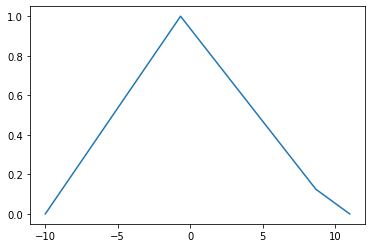

In [119]:
#(Warner et. al., 2019)
membership1 = fuzz.membership.trimf(x1, [-10, middle_1, 10])
plt.plot(x1, membership1)
plt.show()


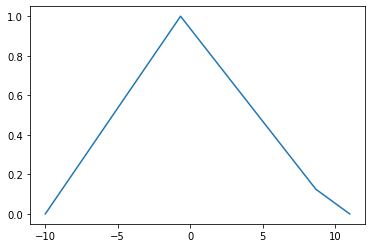

In [120]:
membership2 = fuzz.membership.trimf(x2, [-10, middle_2, 10])
plt.plot(x2, membership2)
plt.show()

In [121]:
#If input 1 = x and input 2 = y, then output is sinc function
def sinc_2d(input1, input2):
    result = (np.sin(input1) * np.sin(input2))/(input1*input2)
    return result

In [122]:
##let input 1 be 2 and let input 3 be 4 (Topperly, 2021)
in1 = membership1[1]
in2 = membership2[3]
w_value = min(in1, in2)
y1 = sinc_2d(2, 4)
defuzz = (w_value * y1) / w_value
defuzz

-0.08601982019984428

In [125]:
 ##problem 2
def non_linear(x1, x2, x3):
    result = (1 + (x1**0.5) + (x2**-1) + (x3**-1.5))**2
    return result
    
x_1_train = np.random.uniform(1,7, 10)
x_2_train = np.random.uniform(1,7, 10)
x_3_train = np.random.uniform(1,7, 10)

x_1_test = np.random.uniform(1.5, 5.6, 10)
x_2_test = np.random.uniform(1.5, 5.6, 10)
x_3_test = np.random.uniform(1.5, 5.6, 10)

y_train = non_linear(x_1_train, x_2_train, x_3_train)
y_test = non_linear(x_1_test, x_2_test, x_3_test)

In [126]:
##to create the model I used the pyFUME package 
##(Fuchs et. al., 2020)
import pandas as pd
from pyfume import *
y_train = pd.DataFrame(y_train)
y_train.columns = ["train"]
x_train = pd.concat([pd.DataFrame(x_1_train), pd.DataFrame(x_2_train), pd.DataFrame(x_3_train)], axis=1)
x_train.columns = ["x1", "x2", "x3"]
x_train = x_train.to_numpy()
y_train1 = y_train.to_numpy()
y_train = y_train1.flatten()

y_test = pd.DataFrame(y_test)
y_test.columns = ["test"]
x_test = pd.concat([pd.DataFrame(x_1_test), pd.DataFrame(x_2_test), pd.DataFrame(x_3_test)], axis=1)
x_test.columns = ["x1", "x2", "x3"]
x_test = x_test.to_numpy()
y_test1 = y_test.to_numpy()
y_test = y_test1.flatten()


In [147]:
variable_names = ["x1", "x2", "x3"]
fs=FeatureSelector(dataX=x_train, dataY=y_train, nr_clus=3, variable_names=variable_names)
selected_feature_indices, variable_names=fs.wrapper()

Evaluating feature sub set including: ['x1']
The selected features have a MAE of: 2.891443512863539
The following features were selected: ['x1']


In [148]:
x_train = x_train[:, selected_feature_indices]
x_test = x_test[:, selected_feature_indices]

In [149]:
cl = Clusterer(x_train=x_train, y_train=y_train, nr_clus=2)
cluster_centers, partition_matrix, _ = cl.cluster(method="fcm")

In [150]:
ae = AntecedentEstimator(x_train=x_train, partition_matrix=partition_matrix)
antecedent_parameters = ae.determineMF()
antecedent_parameters

[('gauss', array([5.64535237, 1.69097102])),
 ('gauss', array([1.8217247 , 1.88210544]))]

In [151]:
fsc=FireStrengthCalculator(antecedent_parameters=antecedent_parameters, nr_clus=1, variable_names=variable_names)
firing_strengths = fsc.calculate_fire_strength(data=x_train)
firing_strengths

array([[0.6238679 ],
       [0.04887931],
       [0.09728148],
       [0.30778416],
       [0.99660205],
       [0.47984493],
       [0.99365175],
       [0.73026199],
       [0.04304566],
       [0.90427704]])

In [152]:
ce = EstimateConsequentParameters.ConsequentEstimator(x_train=x_train, y_train=y_train, firing_strengths=firing_strengths)
consequent_parameters = ce.suglms()
consequent_parameters

array([[1.3532604 , 7.54786515]])

In [153]:
simpbuilder = SugenoFISBuilder(antecedent_sets=antecedent_parameters, consequent_parameters=consequent_parameters, variable_names=variable_names)
model = simpbuilder.get_model()

 * Detected 1 rules / clusters
 * Code saved to file Simpful_code.py
 * Detected Sugeno model type


In [154]:

test=SugenoFISTester(model=model, test_data=x_test, variable_names=variable_names, golden_standard=y_test)
MSE = test.calculate_MSE()
MSE

1.546448108027078